# EDA - OpenFoodFacts - David Faget Caño

___

El objetivo de este notebook es explorar un conjunto de datos de OpenFoodFacts para obtener estadísticas útiles y preparar la información necesaria para la extracción de datos nutricionales a partir de imágenes de productos.

Seguiremos la estructura siguiente:

____

*Importación de librerías*
1. *Carga y limpieza de datos*

    1.1. *Carga de datos*

    1.2. *Exploración preliminar de los datos*

    1.3. *Limpieza básica de los datos*
    
    1.4. *Análisis de los NaN*

2. *EDA*

    2.1. *Preparación de los datos para nuestra tarea*

    2.2. *Análisis de la energía (kcal)*

    2.3. *Análisis de los macronutrientes*

    2.4. *Análisis de los micronutrientes*

    2.5. *Análisis de las imágenes*

*Identificación de los datos necesarios para extraer las tablas de las imágenes*

____

# Importación de librerías

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
from PIL import Image

from sklearn.cluster import KMeans

# 1. Carga y limpieza de datos

## 1.1. Carga de datos

In [ ]:
%cd C:/Users/.

In [24]:
data_path = "data/en.openfoodfacts.org.products.csv"

En la siguiente celda, implementamos la opción de cargar solo una fracción de los datos (1/factor) debido al gran tamaño de los datos originales. Esto permite que la ejecución del código de EDA sea más rápida a lo largo del desarrollo.


In [87]:
total_rows = sum(1 for _ in open(data_path))
factor = 4

df_data = pd.read_table(data_path, sep='\t', low_memory=False, nrows=total_rows // factor)

## 1.2. Exploración preliminar de los datos

Esta sección se centra en realizar una exploración preliminar de los datos, sin eliminar ninguna columna. En la sección 2 (EDA) nos quedaremos solo con los atributos nutricionales, ya que es lo que nos interesa en este ejercicio.

In [26]:
df_data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1729015217,2024-10-15T18:00:17Z,prepperapp,1.729015e+09,2024-10-15T18:00:17Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,del51,1.707490e+09,2024-02-09T14:47:37Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,NaN,1.707490e+09,2024-02-09T14:47:37Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,208,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1544207680,2018-12-07T18:34:40Z,1544207683,2018-12-07T18:34:43Z,NaN,1.707608e+09,2024-02-10T23:36:06Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,284,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1547120245,2019-01-10T11:37:25Z,1563551052,2019-07-19T15:44:12Z,NaN,1.707610e+09,2024-02-11T00:10:57Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tras analizar los datos, observamos en un primer lugar que hay una gran cantidad de NaN. Analizaremos esto más detenidamente en las proximas secciones. Obtengamos más información acerca de los datos:

In [27]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867686 entries, 0 to 867685
Columns: 206 entries, code to acidity_100g
dtypes: float64(131), int64(3), object(72)
memory usage: 1.3+ GB


Vamos a hacer una función que nos desvele con qué tipo de datos vamos a trabajar:

In [28]:
def count_data_types(df):
    # Obtenemos los tipos de datos de cada columna
    dtypes = df.dtypes
    
    # Creamos un diccionario vacío para almacenar los conteos
    type_counts = {}
    
    # Recorremos los tipos de datos
    for dtype in dtypes:
        # Convertimos dtype a cadena para un manejo más fácil
        dtype_str = str(dtype)
        
        # Si el dtype ya está en el diccionario, enotnces incrementamos su conteo
        if dtype_str in type_counts:
            type_counts[dtype_str] += 1
        else:
            # De lo contrario, inicializar el conteo en 1
            type_counts[dtype_str] = 1
    
    return type_counts


count_data_types(df_data)

{'int64': 3, 'object': 72, 'float64': 131}

Por último, como análisis preliminar básico, podemos ver el nombre de todas las columnas:

In [29]:
print(list(df_data.columns))

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by', 'last_updated_t', 'last_updated_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'packaging_en', 'packaging_text', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'ingredients_tags', 'ingredients_analysis_tags', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutrition_data', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'p

## 1.3. Limpieza básica de los datos

A continuación, procederemos a realizar una limpieza básica que no implique pérdida de información. Eliminaremos lo siguiente:

- Todas las filas y columnas que estén completamente vacías.
- Todas las filas duplicadas.

In [88]:
num_rows, num_cols = df_data.shape

# Eliminamos filas sin datos
df_data.dropna(how='all', inplace=True)
print('Número de filas vacías eliminadas: {}'.format(num_rows - df_data.shape[0]))

# Eliminamos columnas sin datos
df_data.dropna(how='all', axis=1, inplace=True)
print('Número de variables vacías eliminadas: {}'.format(num_cols - df_data.shape[1]))

# Eliminamos filas duplicadas
num_duplicates = df_data.duplicated().sum()
df_data.drop_duplicates(inplace=True)
print('Número de duplicados eliminados: {}'.format(num_duplicates))

Número de filas vacías eliminadas: 0
Número de variables vacías eliminadas: 6
Número de duplicados eliminados: 1


## 1.4. Análisis de los NaN

Tal y como vimos en la exploración preliminar, nuestros datos se caracterizan por una elevada presencia de NaN. Vamos a explorar este punto más en profundidad.

En primer lugar, vamos a hacer una función que nos muestre el porcentaje de NaN en cada columna:

In [31]:
def nan_level(dataset=pd.DataFrame()):
    # Calculamos el porcentaje de NaN por columna
    missing_percent = dataset.isna().mean()

    # Gráfico de barras que muestra el porcentaje de NaN por columna
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Definimos una paleta de colores personalizada basada en el porcentaje de NaN (verde, naranja y rojo según el nivel)
    colors = ['#4CAF50' if p < 0.2 else '#FF9800' if p <= 0.4 else '#F44336' for p in missing_percent]
    
    # Creamos el gráfico de barras
    bars = ax.bar(missing_percent.index, missing_percent.values * 100, color=colors, alpha=0.9)

    ax.set_title('Porcentaje de Valores Faltantes en Cada Columna', fontsize='xx-large')
    ax.set_ylabel('Valores Faltantes (%)', fontsize='x-large')
    plt.xticks(rotation=90)
    plt.show()

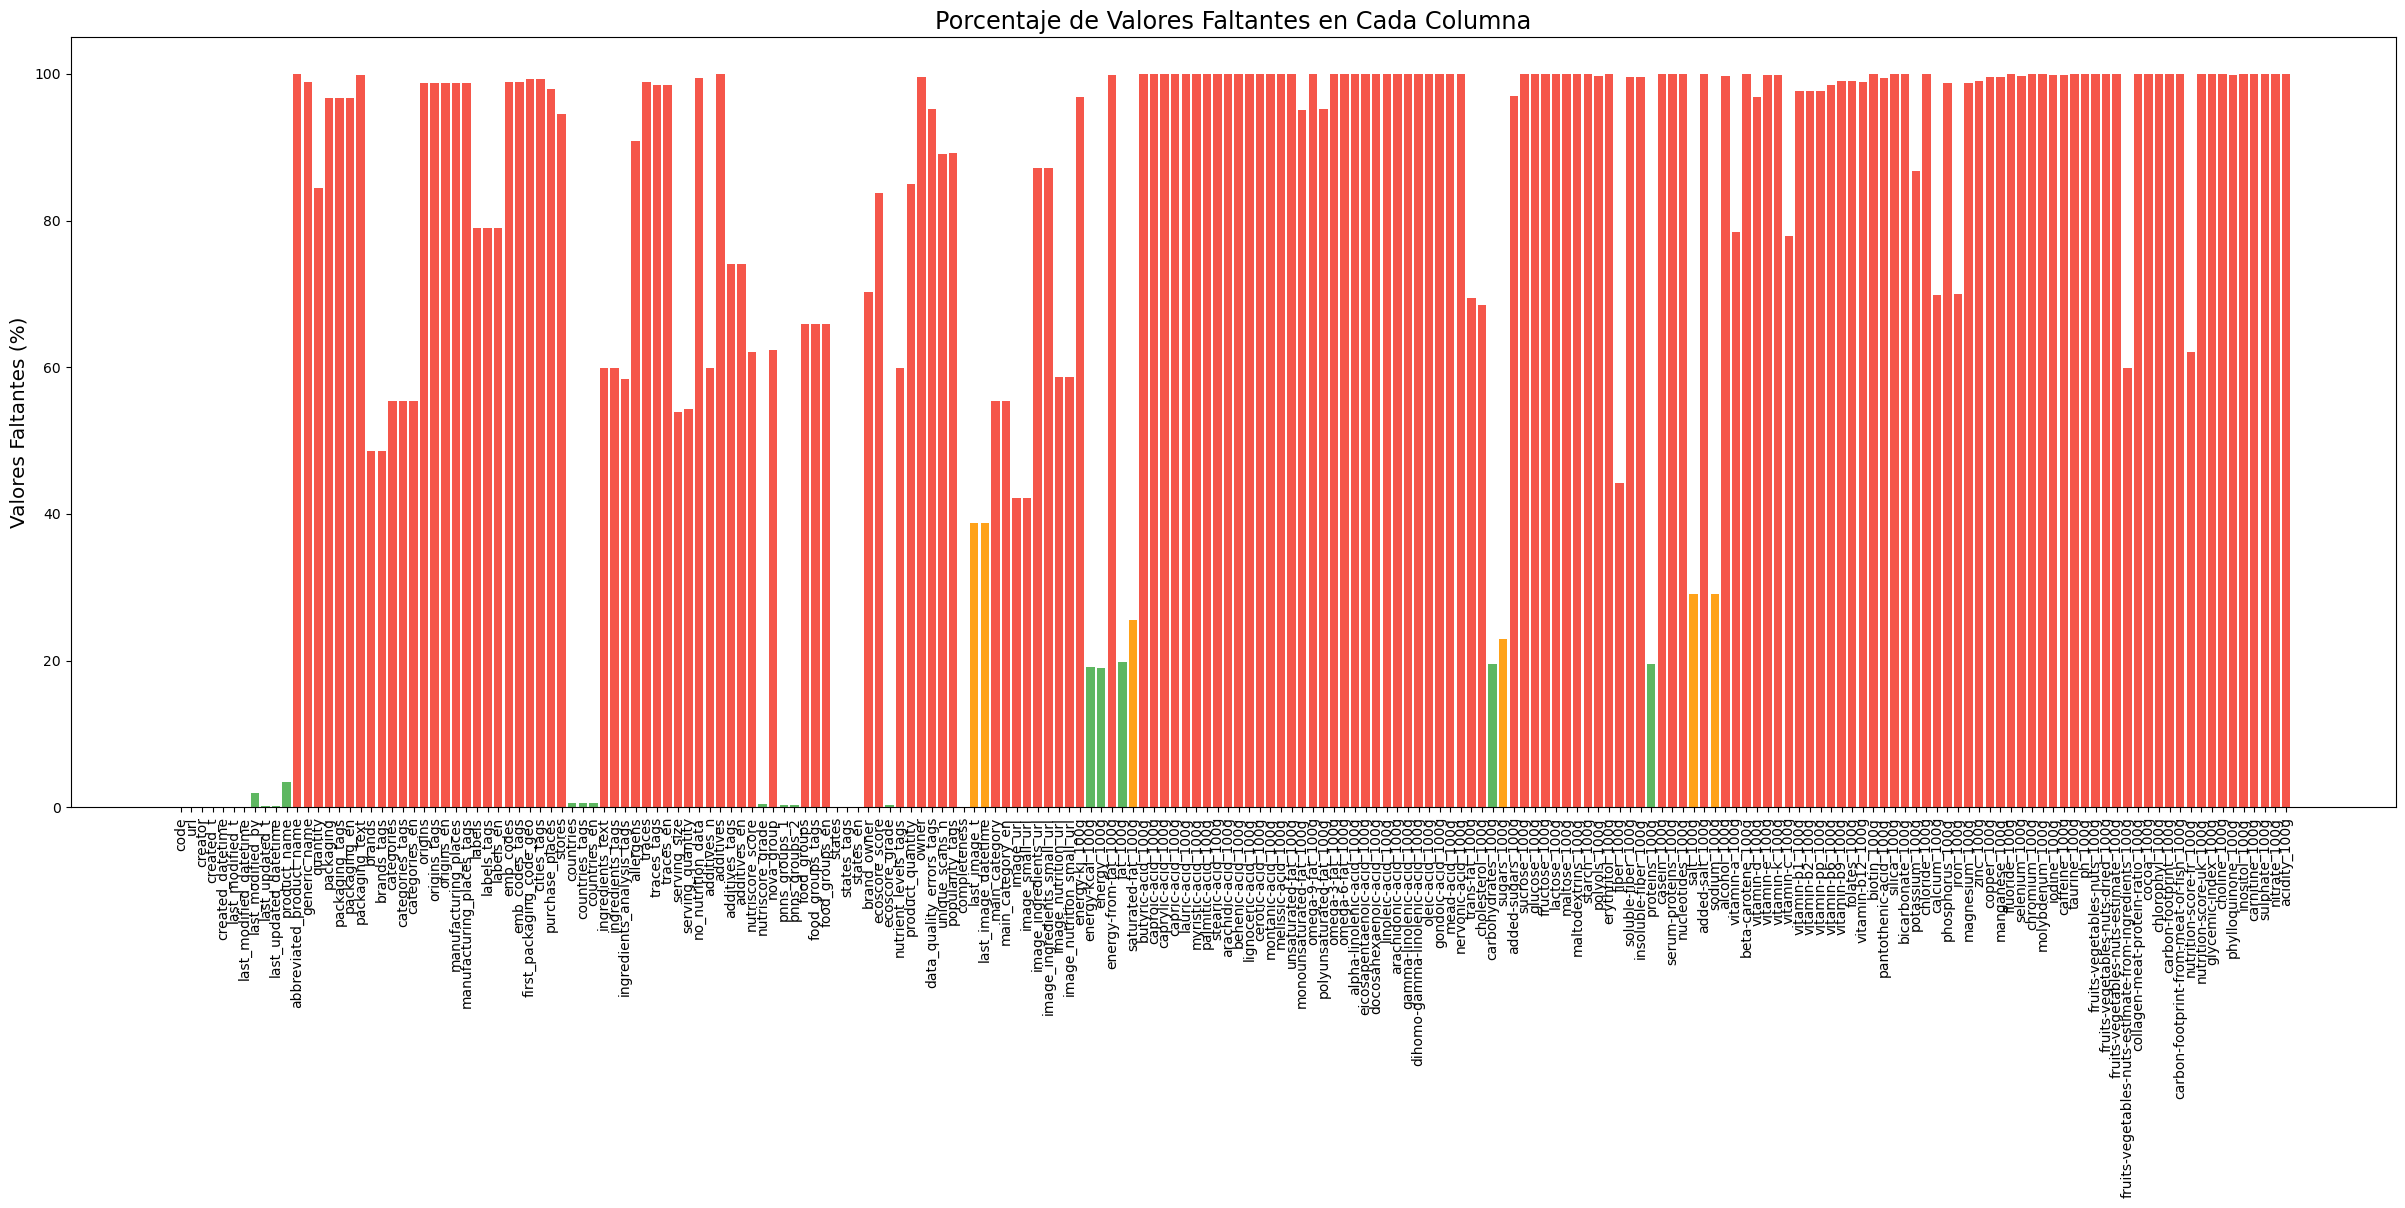

In [32]:
nan_level(dataset=df_data)

Veamos ahora qué columnas son las que tienen más de un 90% de NaN

In [33]:
# Calculamos el porcentaje de NaN en cada columna
missing_percent = df_data.isna().mean() * 100

# Filtrado de columnas donde el porcentaje de valores NaN es mayor al 90%
columns_with_nan = missing_percent[missing_percent > 90].index.to_list()

columns_with_nan

['abbreviated_product_name',
 'generic_name',
 'packaging',
 'packaging_tags',
 'packaging_en',
 'packaging_text',
 'origins',
 'origins_tags',
 'origins_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities_tags',
 'purchase_places',
 'stores',
 'allergens',
 'traces',
 'traces_tags',
 'traces_en',
 'no_nutrition_data',
 'additives',
 'owner',
 'data_quality_errors_tags',
 'energy-kj_100g',
 'energy-from-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'unsaturated-fat_100g',
 'monounsaturated-fat_100g',
 'omega-9-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapen

Observamos que más de la mitad de las columnas tienen más de un 90% de NaN.

# 2. EDA

## 2.1. Preparación de los datos para nuestra tarea

Ahora que ya tenemos una idea general del aspecto de los datos, vamos a concentrarnos en la tarea de este ejercicio. El objetivo de la segunda parte del ejercicio es extraer información de la tabla de información nutricional, por lo que solo nos interesarán los productos que tengan una imagen de la tabla asociada.

In [80]:
df_data = df_data.dropna(subset=["image_nutrition_url"])
print("Filas eliminadas:", num_rows-df_data.shape[0])

Filas eliminadas: 509367


Puesto que hay muchas columnas en el dataframe, se podría hacer un EDA muy extenso e interesante (analizar los datos de fechas y trabajar con series temporales, relacionar los aditivos con el Nutri-Score,...). Sin embargo, nosotros vamos a centrarnos en realizar un EDA de los atributos nutricionales. Para ello, optaremos por quedarnos con las columnas nutricionales con menor porcentaje de NaN (pongamos menor que 30%) y descartaremos todas las demás. Sin embargo, en el caso ideal, habría que analizar también las demás columnas nutricionales aunque tengan un alto porcentaje de NaN, ya que son atributos que aparecen en alguna tabla nutricional. Este alto porcentaje en algunas columnas se explica porque no todos los alimentos tienen la misma tabla nutricional. Vamos a detallar más este último punto con el ejemplo de la cafeína:

In [35]:
nan_percentage = df_data["caffeine_100g"].isna().mean() * 100
nan_percentage

99.8972982175101

Vemos que aproximadamente el 99.9% de los valores de la columna de cafeína son NaN. Esto se explica porque solo un pequeño conjunto de bebidas contienen cafeína, y esto mismo sucede con otros muchos nutrientes. En un contexto de tiempo limitado, y para poder extraer la información más pertinente en este ejercicio, nos centraremos entonces en los nutrientes predominantes en la mayoría de alimentos.

In [36]:
# Calculamos el umbral de NaN (menos del 30%)
threshold = 0.30 * len(df_data)

# Filtrado de las columnas que tienen menos del 30% de NaN
df_data = df_data.loc[:, df_data.isna().sum() < threshold]

print("Número de columnas restantes:", df_data.shape[1])

Número de columnas restantes: 37


In [37]:
df_data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'last_modified_by',
       'last_updated_t', 'last_updated_datetime', 'product_name', 'countries',
       'countries_tags', 'countries_en', 'nutriscore_grade', 'pnns_groups_1',
       'pnns_groups_2', 'states', 'states_tags', 'states_en', 'ecoscore_grade',
       'completeness', 'last_image_t', 'last_image_datetime', 'image_url',
       'image_small_url', 'image_nutrition_url', 'image_nutrition_small_url',
       'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g'],
      dtype='object')

Podemos eliminar algunas columnas innecesarias para el EDA, ya que nos enfocamos únicamente en la información nutricional.

In [38]:
columns_to_keep = ["code","product_name","image_nutrition_url","energy-kcal_100g", 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutriscore_grade'] 

nutrition_columns = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'] 

df_data = df_data[columns_to_keep]

Vamos a examinar algunas estadísticas básicas de estas columnas:

In [39]:
df_data.describe()

,code,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
count,3.583190e+05,3.388430e+05,340156.000000,333973.000000,340102.000000,336302.000000,339995.000000,306122.000000,306121.000000
mean,3.000556e+11,4.190731e+10,12.696767,4.593937,30.653035,12.964408,9.501194,2.659996,1.064027
std,3.199673e+11,2.439434e+13,19.410362,8.485513,174.493260,19.555677,172.433612,59.037272,23.615327
min,1.000000e+00,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.167968e+10,9.782609e+01,0.000000,0.000000,4.761905,0.000000,0.800000,0.125000,0.050000
50%,8.490902e+10,2.571429e+02,5.952381,1.400000,20.000000,3.571429,5.714286,0.685000,0.274000
75%,6.625725e+11,4.000000e+02,20.000000,6.410256,54.000000,17.000000,12.500000,1.458333,0.583333
max,8.506450e+11,1.420000e+16,3220.000000,1424.528200,99999.000000,539.000000,100000.000000,14583.333333,5833.333333


Observamos que hay varios outliers con valores nutricionales que son imposibles por definición. Procederemos a aplicar los siguientes filtros:

- Excluiremos los productos que no tengan datos nutricionales registrados en los atributos que mantenemos. Hay casos en los que todos los atributos considerados tienen un valor de 0, lo cual es relevante.

- Eliminaremos las observaciones que presenten valores nutricionales negativos o superiores a 100 g, ya que no tienen sentido en nuestra medida de cantidad sobre 100 g (también eliminaremos las combinaciones de sumas de macronutrientes que superen 100g, ya que esto es imposible). 

- Dado que los azúcares son parte de los carbohidratos y las grasas saturadas pertenecen a las grasas, eliminaremos las observaciones donde los gramos de azúcar superen los de carbohidratos, así como aquellas en las que las grasas saturadas excedan a las grasas. Aplicaremos el mismo criterio para la sal y el sodio.

In [89]:
# Eliminamos los productos que tengan NaN en todos los atributos que consideramos
df_data = df_data.dropna(subset=nutrition_columns, how='all')
df_data = df_data[(df_data[nutrition_columns] >= 0).all(axis=1)]
df_data = df_data[(df_data[nutrition_columns] <= 100).all(axis=1)]

# Comprobamos todas las combinaciones de sumas de proteínas, grasas y carbohidratos sean menores que 100, ya que lo contrario es imposible.
df_data = df_data[df_data['proteins_100g'] + df_data['fat_100g'] + df_data['carbohydrates_100g'] <= 100]

# Más de 1000kcal se considera imposible para 100 gramos, luego debe de ser un error al registrar los datos
df_data = df_data[df_data['energy-kcal_100g'] <= 1000] 

# La sal está compuesta de sodio, luego no puede haber más sodio que sal
df_data = df_data[df_data['sodium_100g'] <= df_data['salt_100g']] 

# Eliminamos las filas donde los azúcares son mayores que los carbohidratos
df_data = df_data[df_data['sugars_100g'] <= df_data['carbohydrates_100g']]

# Eliminamos las filas donde las grasas saturadas son mayores que las grasas totales
df_data = df_data[df_data['saturated-fat_100g'] <= df_data['fat_100g']]

In [41]:
display(df_data)
df_data.describe()

,code,product_name,image_nutrition_url,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutriscore_grade
0,1,Tonno Rio Mare,https://images.openfoodfacts.org/images/produc...,406.000000,6.600000,4.300000,6.700000,6.700000,80.000000,0.500000,0.200000,d
10,1199,Solène céréales poulet,https://images.openfoodfacts.org/images/produc...,219.000000,5.900000,0.500000,30.300000,1.700000,9.700000,0.464000,0.185600,unknown
14,1885,Compote de poire,https://images.openfoodfacts.org/images/produc...,157.000000,0.000000,0.000000,36.000000,27.000000,0.600000,0.000000,0.000000,a
19,2264,Baguette Poitevin,https://images.openfoodfacts.org/images/produc...,207.000000,6.700000,3.800000,27.500000,0.600000,8.900000,0.400000,0.160000,unknown
27,3827,Suedois saumon,https://images.openfoodfacts.org/images/produc...,172.000000,4.400000,1.200000,23.300000,4.600000,8.400000,3.580000,1.432000,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
867670,850643007405,Organic Avocado Lime Hummus,https://images.openfoodfacts.org/images/produc...,214.285714,14.285714,1.785714,14.285714,3.571429,3.571429,1.339286,0.535714,c
867671,850643007412,Cashew & Almond desser dip spread,https://images.openfoodfacts.org/images/produc...,357.142857,28.571429,5.357143,17.857143,14.285714,7.142857,0.401786,0.160714,unknown
867679,850645008011,Whey protein fruity cereal,https://images.openfoodfacts.org/images/produc...,356.000000,3.240000,3.240000,6.470000,3.240000,74.400000,1.210000,0.485000,d
867681,850645008042,Alani Nu Mimosa pre-workout,https://images.openfoodfacts.org/images/produc...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,b


,code,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
count,2.933920e+05,293392.000000,293392.000000,293392.000000,293392.000000,293392.000000,293392.000000,293392.000000,293392.000000
mean,2.976236e+11,274.385011,13.283693,4.711066,30.610267,12.536777,9.592224,1.363125,0.545249
std,3.188214e+11,186.345781,17.006678,7.621255,28.249355,19.179112,12.093022,3.554128,1.421658
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.175702e+10,110.000000,0.535711,0.000000,4.700000,0.000000,1.300000,0.130208,0.052083
50%,8.379104e+10,269.841270,7.054674,1.666700,21.428571,3.571400,6.250000,0.700000,0.280000
75%,6.602178e+11,400.000000,20.689700,6.666667,54.300000,16.666700,13.333300,1.458333,0.583333
max,8.506450e+11,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000


## 2.2. Análisis de la energía (kcal)

En esta sección, vamos a realizar un breve análisis exploratorio de la energía. Estudiaremos también su relacion con el indicador Nutri-score.

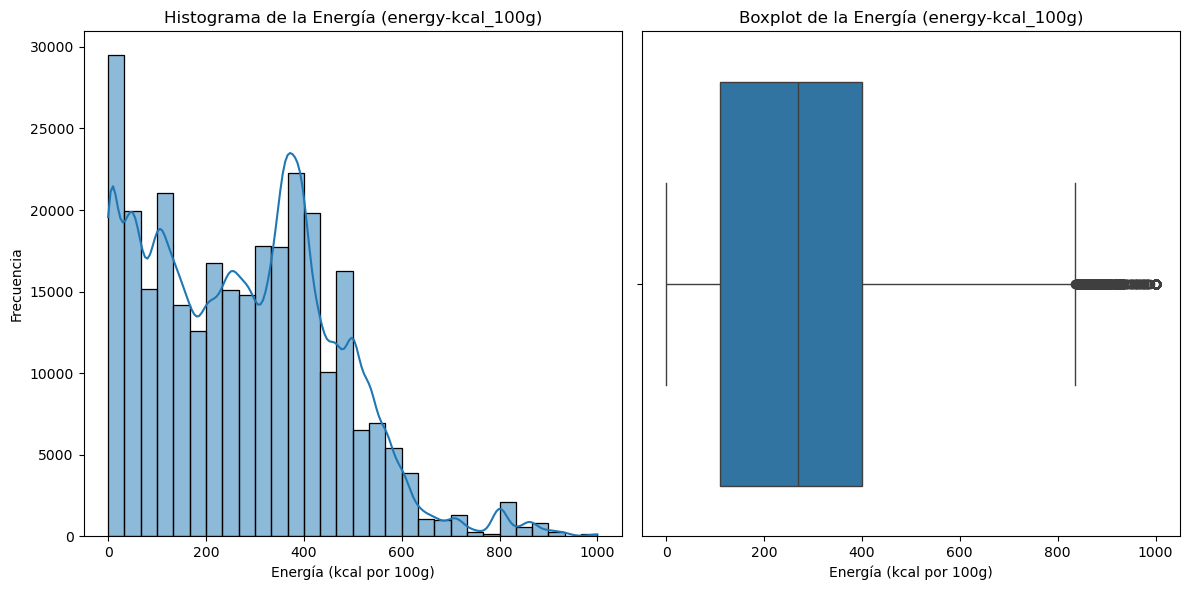


Número de outliers en 'energy-kcal_100g': 1769


In [42]:
# Visualización de la Distribución
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df_data['energy-kcal_100g'], bins=30, kde=True)
plt.title('Histograma de la Energía (energy-kcal_100g)')
plt.xlabel('Energía (kcal por 100g)')
plt.ylabel('Frecuencia')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_data['energy-kcal_100g'])
plt.title('Boxplot de la Energía (energy-kcal_100g)')
plt.xlabel('Energía (kcal por 100g)')

plt.tight_layout()
plt.show()

# Identificación de Outliers
Q1 = df_data['energy-kcal_100g'].quantile(0.25)
Q3 = df_data['energy-kcal_100g'].quantile(0.75)
IQR = Q3 - Q1

# Definición de límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificación de outliers
outliers = df_data[(df_data['energy-kcal_100g'] < lower_bound) | (df_data['energy-kcal_100g'] > upper_bound)]
print(f"\nNúmero de outliers en 'energy-kcal_100g': {outliers.shape[0]}")

No eliminamos los outliers en el análisis de calorías e información nutricional porque muchos alimentos como los aceites naturalmente tienen valores extremos, y eliminarlos podría distorsionar la representación real de la diversidad en la composición nutricional. De hecho, veamos cuáles son los productos más densos calóricamente (teniendo en cuenta que hemos eliminado los de más de 1000kcal) y comprobemos esto último:

In [82]:
df_data.sort_values(by='energy-kcal_100g', ascending=False, inplace=False)[['product_name','energy-kcal_100g']][:3]

,product_name,energy-kcal_100g
785479,Omega-3,1000.0
725594,Omega,1000.0
644209,Blanc manger coco,1000.0


Observamos que los productos mostrados son efectivamente muy densos calóricamente, y que no tendría sentido eliminar estas observaciones por mucho que sean consideradas como outliers.

### 2.2.1. Relación con el nutriscore

Vamos a estudiar brevemente la relación entre la energía y el indicador Nutri-score. Este indicador toma los valores a,b,c,d,e, siendo a el indicador más saludable y e el menos saludable.

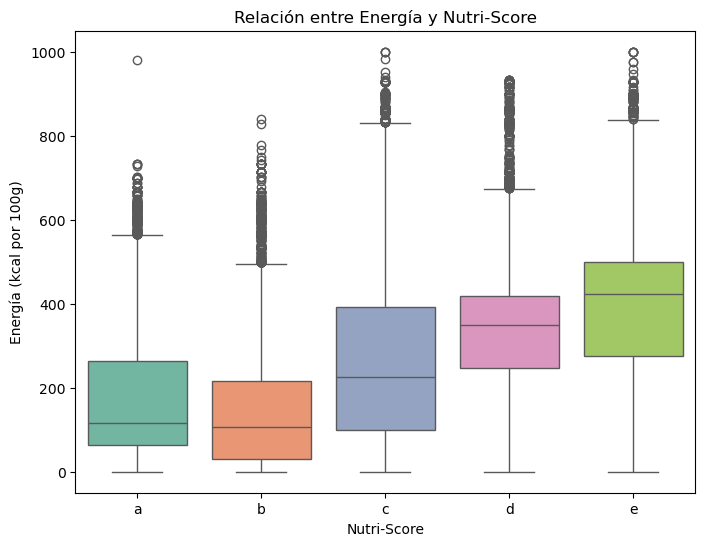

In [44]:
# Definimos el orden de los valores del Nutri-Score (de mejor a peor)
nutri_order = ['a', 'b', 'c', 'd', 'e']

# Convertimos 'nutriscore_grade' a tipo categórico con el orden definido
df_data['nutriscore_grade'] = pd.Categorical(df_data['nutriscore_grade'], categories=nutri_order, ordered=True)

# Creamos el gráfico
plt.figure(figsize=(8, 6))
sns.boxplot(x='nutriscore_grade', y='energy-kcal_100g', data=df_data, hue='nutriscore_grade', palette='Set2', legend=False)
plt.title('Relación entre Energía y Nutri-Score')
plt.xlabel('Nutri-Score')
plt.ylabel('Energía (kcal por 100g)')
plt.show()


En general, como esperábamos, los alimentos más calóricos tienden a tener un indicador menos favorable. Sin embargo, resulta sorprendente que los alimentos con un Nutri-Score de B tienden a ser ligeramente menos calóricos que aquellos con un Nutri-Score de A.

## 2.3. Análisis de los macronutrientes

Los principales macronutrientes son los carbohidratos, las proteínas y las grasas. Vamos a analizar estas tres principales categorías.

En primer lugar, vamos a ver las estadísticas básicas de estos atributos:

In [45]:
# Seleccionamos las columnas de interés (macronutrientes principales)
cols_macro = ['fat_100g', 'carbohydrates_100g', 'proteins_100g']

# Generamos estadísticas descriptivas
df_data[cols_macro].describe()

,fat_100g,carbohydrates_100g,proteins_100g
count,293392.000000,293392.000000,293392.000000
mean,13.283693,30.610267,9.592224
std,17.006678,28.249355,12.093022
min,0.000000,0.000000,0.000000
25%,0.535711,4.700000,1.300000
50%,7.054674,21.428571,6.250000
75%,20.689700,54.300000,13.333300
max,100.000000,100.000000,100.000000


Veamos ahora la distribución de los macronutrientes:

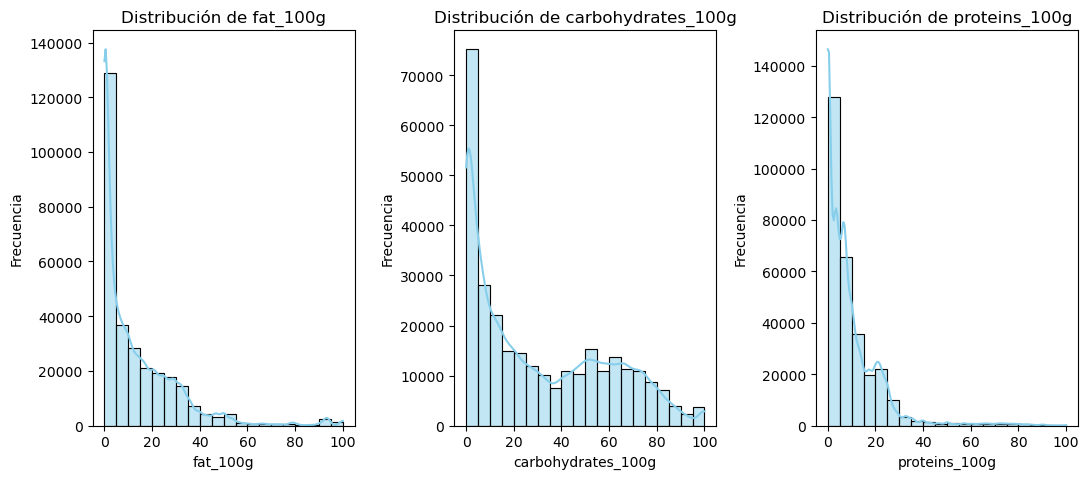

In [46]:
# Definimos el tamaño general de las figuras
plt.figure(figsize=(11, 9))

# Histogramas
for i, col in enumerate(cols_macro):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_data[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que una parte significativa de los alimentos contiene 0 gramos de ciertos macronutrientes. Esto es común en casos como bebidas que solo contienen azúcares, y por lo tanto carbohidratos, pero carecen de grasas y proteínas. También puede ocurrir que alimentos como carne o huevo no tengan carbohidratos.

Además, las distribuciones de grasas y proteínas siguen un patrón de decrecimiento exponencial, lo que sugiere que la mayoría de los alimentos tienen cantidades moderadas o bajas de estos macronutrientes. Por otro lado, los carbohidratos muestran un comportamiento distinto, con un pico notable entre los 45 y 65 gramos por cada 100 gramos de producto. Este patrón se debe a que los carbohidratos suelen ser el macronutriente predominante en muchos alimentos procesados o de consumo habitual, lo que explica la mayor concentración en ese rango.

Ahora observaremos que la correlación entre los macronutrientes (carbohidratos, proteínas y grasas) es bastante débil, lo que indica que estos componentes son relativamente independientes entre sí en la mayoría de los alimentos. Es decir, la presencia de uno de estos macronutrientes en grandes o pequeñas cantidades no necesariamente implica que los otros estarán presentes en proporciones similares.

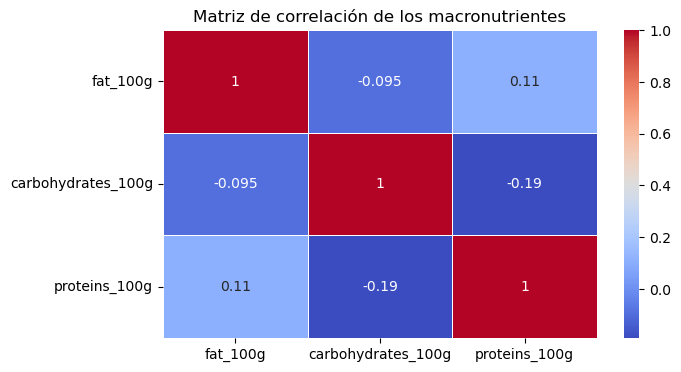

In [47]:
# Calculamos la matriz de correlación
correlation_matrix = df_data[cols_macro].corr()

# Visualizamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación de los macronutrientes')
plt.show()

Obtengamos ahora información más detallada sobre las medias de los macronutrientes, para así poder comparar mejor su presencia:

C:\Users\E108472\AppData\Local\Temp\ipykernel_25064\4022964234.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, palette='viridis')


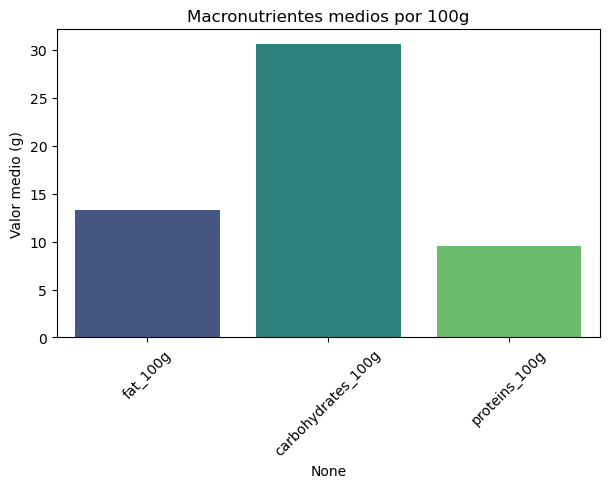

In [48]:
# Calculamos la media de cada macronutriente
means = df_data[cols_macro].mean()

# Creamos un gráfico de barras
plt.figure(figsize=(7, 4))
sns.barplot(x=means.index, y=means.values, palette='viridis')
plt.title('Macronutrientes medios por 100g')
plt.ylabel('Valor medio (g)')
plt.xticks(rotation=45)
plt.show()

Con el siguiente gráfico podemos comprobar que hemos filtrado bien y que no hay ningún valor por encima de la diagonal, lo que implicaría que la suma de varios macronutrientes es superior a 100gr:

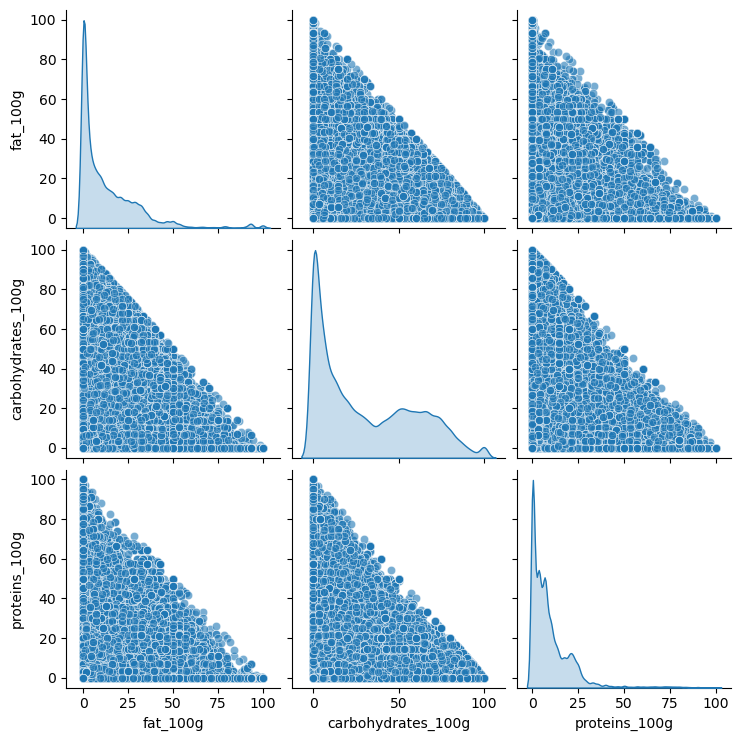

In [49]:
sns.pairplot(df_data[cols_macro], diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()

Ahora observemos la distribución de cada macronutriente con un gráfico de violín:

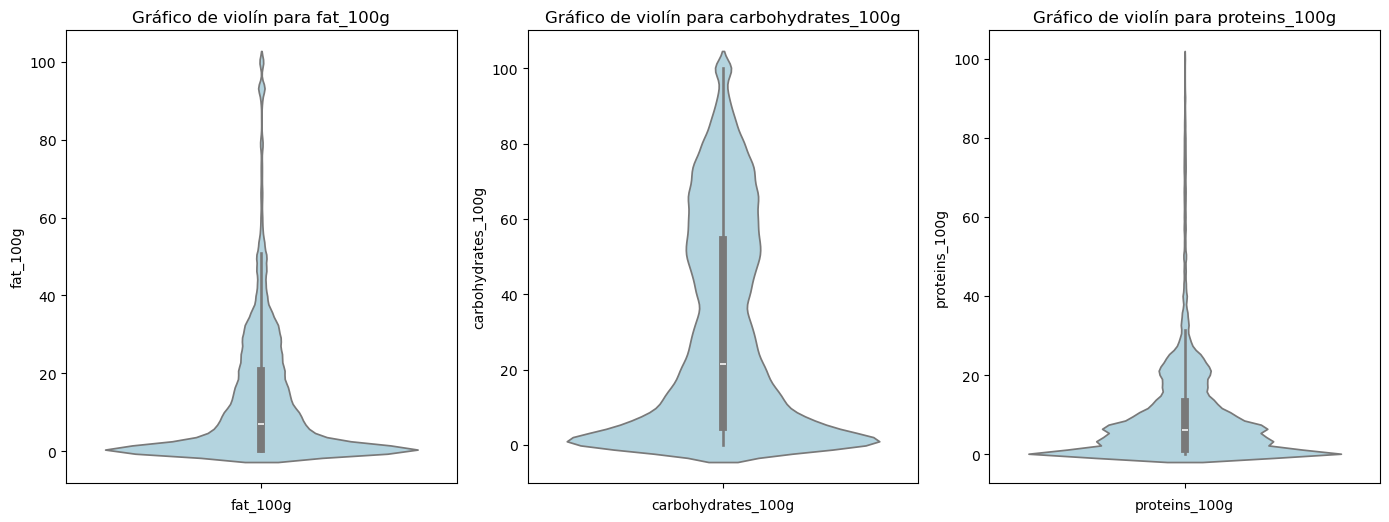

In [50]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cols_macro):
    plt.subplot(2, 3, i+1)
    sns.violinplot(data=df_data[col], color='lightblue')
    plt.title(f'Gráfico de violín para {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Por último, observemos en qué medida contribuye cada macronutriente al valor calórico mediante una matriz de correlación:

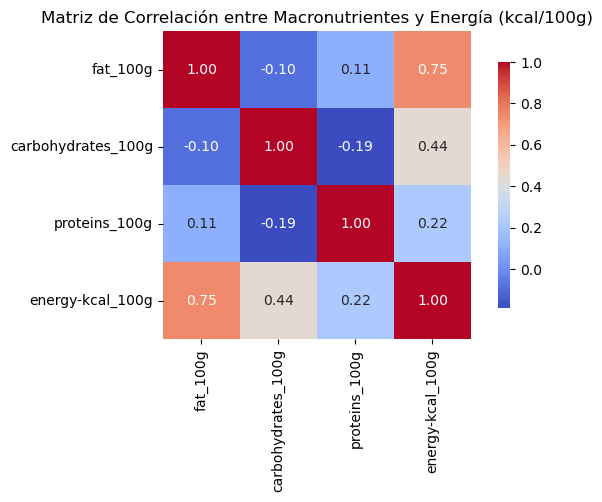

In [51]:
correlation_matrix = df_data[cols_macro + ['energy-kcal_100g']].corr()

# Visualizamos la matriz de correlación
plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Macronutrientes y Energía (kcal/100g)')
plt.show()

Los resultados son lógicos. En efecto, la correlación entre el contenido de grasas y las calorías es de 0.75, lo que indica una fuerte relación positiva; es decir, a medida que aumenta la cantidad de grasas, también tienden a aumentar las calorías. En cambio, la correlación entre los carbohidratos y las calorías es de 0.49, lo que sugiere una relación moderada. Por último, la correlación entre las proteínas y las calorías es de 0.23, indicando una relación débil, lo que sugiere que las proteínas tienen menos impacto en el contenido calórico de los alimentos en comparación con las grasas y los carbohidratos.

### 2.3.1. Relación entre los carbohidratos y los azúcares

Sabemos que los azúcares son tipos de carbohidratos, por lo que esperamos tener una correlación positiva entre estas dos variables. No obstante, el hecho de tener carbohidratos no implica necesariamente la presencia de azúcares (el inverso sí es cierto), por lo que por sentido común esta correlación no debería ser cercana a 1. Veámoslo:

In [52]:
# Calculamos la correlación entre carbohidratos y azúcares
carbohydrates = df_data['carbohydrates_100g']
sugars = df_data['sugars_100g']

correlation = carbohydrates.corr(sugars)
print(f'Correlación entre Carbohidratos y Azúcares: {correlation}')

Correlación entre Carbohidratos y Azúcares: 0.6475437614554858


Podemos realizar un análisis más exhaustivo:

C:\Users\E108472\AppData\Local\Temp\ipykernel_25064\1191204500.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='carbohydrate_group', y='sugars_100g', data=df_data, palette='Set2')


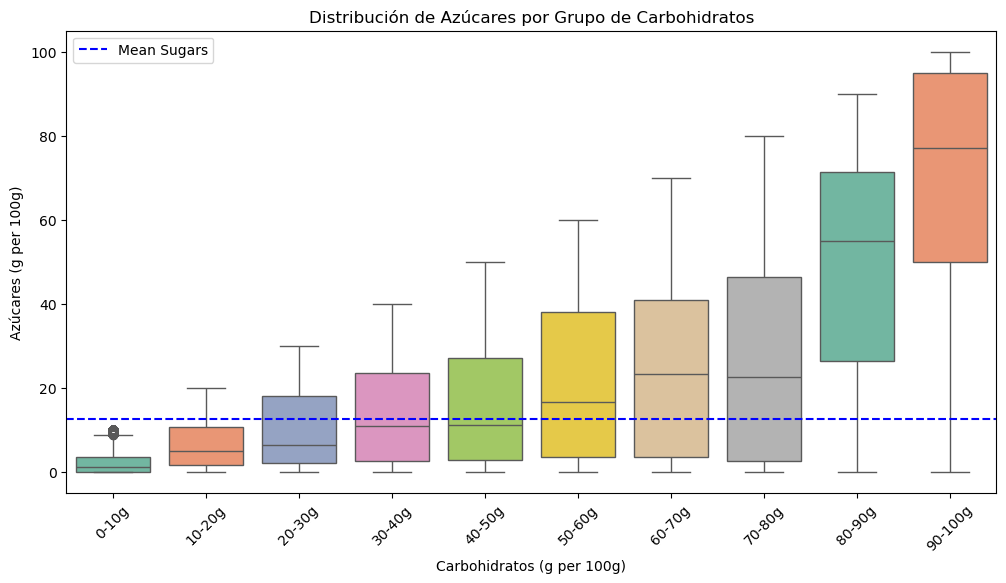

In [53]:
# Creamos una nueva columna categórica para agrupar los carbohidratos en rangos
df_data['carbohydrate_group'] = pd.cut(df_data['carbohydrates_100g'], 
                                         bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                         labels=['0-10g', '10-20g', '20-30g', '30-40g', '40-50g', 
                                                 '50-60g', '60-70g', '70-80g', '80-90g', '90-100g'])

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='carbohydrate_group', y='sugars_100g', data=df_data, palette='Set2')
plt.title('Distribución de Azúcares por Grupo de Carbohidratos')
plt.xlabel('Carbohidratos (g per 100g)')
plt.ylabel('Azúcares (g per 100g)')
plt.axhline(y=df_data['sugars_100g'].mean(), color='blue', linestyle='--', label='Mean Sugars')
plt.legend()
plt.xticks(rotation=45)  
plt.show()


Notamos que a medida que aumentan los carbohidratos, también lo hace la cantidad de azúcar. Sin embargo, la relación entre ambos no es lineal: cuando consumimos una cantidad muy alta de carbohidratos (entre 90 y 100 g), más de la mitad de esos carbohidratos son azúcares, lo que probablemente se deba a la presencia de bebidas azucaradas en nuestros datos. En cambio, en un rango medio de carbohidratos (por ejemplo, de 40 a 50 g), el contenido promedio de azúcar no alcanza la mitad.

Con el siguiente gráfico podemos comprobar que no hay ningún valor por encima de la diagonal, lo que significaría que hay más azúcares que carbohidratos (es imposible y ya lo hemos diltrado antes):

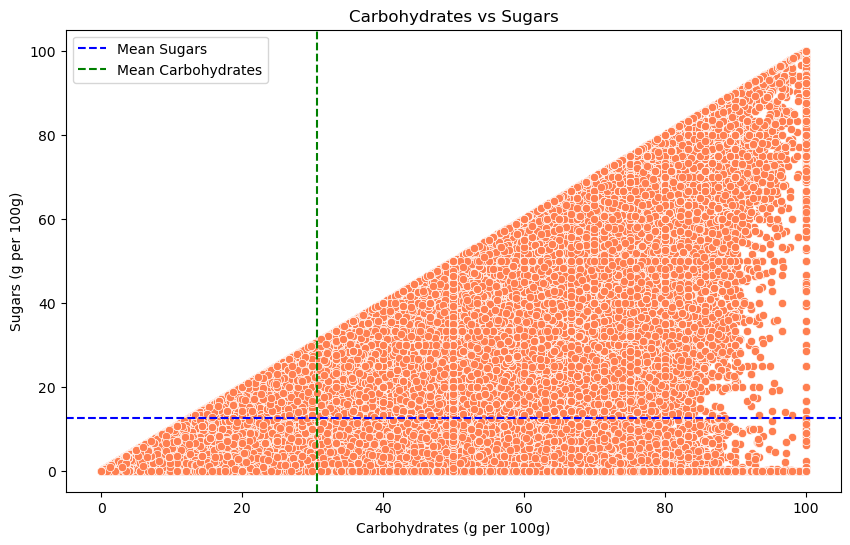

In [54]:
# Gráfico de dispersión entre carbohidratos y azúcares
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_data['carbohydrates_100g'], y=df_data['sugars_100g'], color='coral')
plt.title('Carbohydrates vs Sugars')
plt.xlabel('Carbohydrates (g per 100g)')
plt.ylabel('Sugars (g per 100g)')
plt.axhline(y=df_data['sugars_100g'].mean(), color='blue', linestyle='--', label='Mean Sugars')
plt.axvline(x=df_data['carbohydrates_100g'].mean(), color='green', linestyle='--', label='Mean Carbohydrates')
plt.legend()
plt.show()

### 2.3.2. Relación entre las grasas y las grasas saturadas

Al igual que para el azúcar, calculamos la correlación, que esperamos que sea positiva pero no cercana a 1:

In [55]:
# Calcular la correlación entre grasas totales y grasas saturadas
fat = df_data['fat_100g']
saturated_fat = df_data['saturated-fat_100g']

correlation = fat.corr(saturated_fat)
print(f'Correlación entre Grasas Totales y Grasas Saturadas: {correlation}')

Correlación entre Grasas Totales y Grasas Saturadas: 0.6942688366172031


Obtenemos información más detallada:

C:\Users\E108472\AppData\Local\Temp\ipykernel_25064\2642670913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fat_group', y='saturated-fat_100g', data=df_data, palette='Set2')


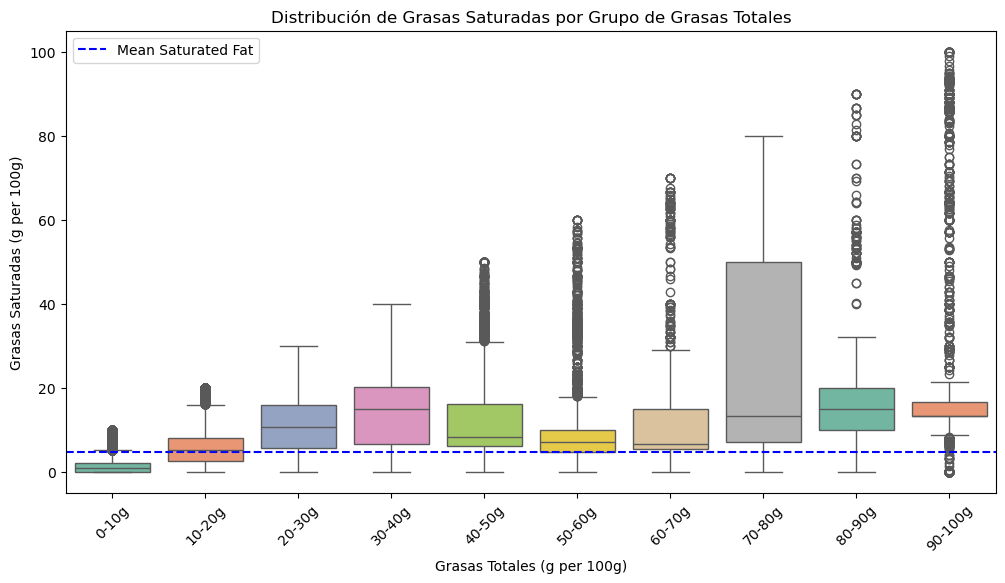

In [56]:
# Creamos una nueva columna categórica para agrupar las grasas totales en rangos
df_data['fat_group'] = pd.cut(df_data['fat_100g'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                               labels=['0-10g', '10-20g', '20-30g', '30-40g', '40-50g', '50-60g', '60-70g', '70-80g', '80-90g', '90-100g'])

# Gráfico de caja
plt.figure(figsize=(12, 6))
sns.boxplot(x='fat_group', y='saturated-fat_100g', data=df_data, palette='Set2')
plt.title('Distribución de Grasas Saturadas por Grupo de Grasas Totales')
plt.xlabel('Grasas Totales (g per 100g)')
plt.ylabel('Grasas Saturadas (g per 100g)')
plt.axhline(y=df_data['saturated-fat_100g'].mean(), color='blue', linestyle='--', label='Mean Saturated Fat')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Sorprendentemente, de media, los alimentos que contienen 30-40g de grasas totales son tamvién los que más grasas saturadas contienen. 

El siguiente gráfico de dispersión muestra que efectivamente las grasas saturadas no son mayores que las grasas totales en ningún producto (lo hemos filtrado anteriormente ya que es imposible que esto suceda):

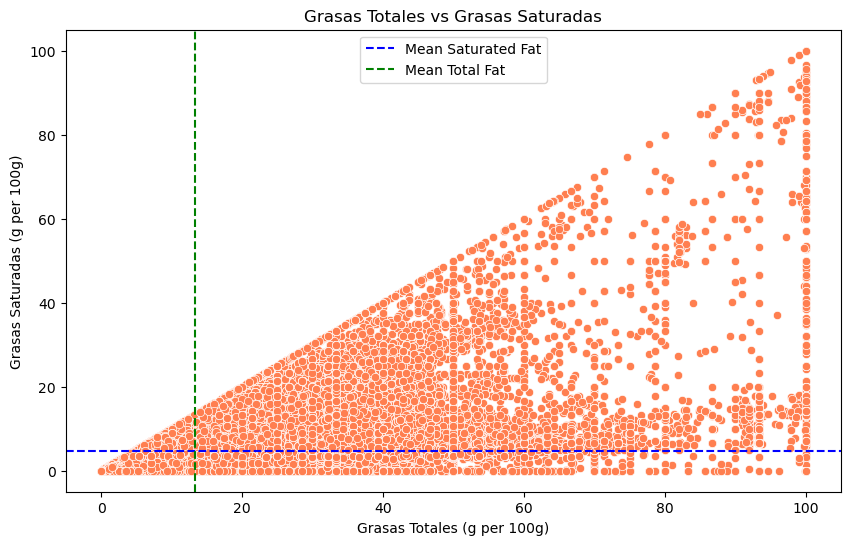

In [57]:
# Gráfico de dispersión entre grasas totales y grasas saturadas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_data['fat_100g'], y=df_data['saturated-fat_100g'], color='coral')
plt.title('Grasas Totales vs Grasas Saturadas')
plt.xlabel('Grasas Totales (g per 100g)')
plt.ylabel('Grasas Saturadas (g per 100g)')
plt.axhline(y=df_data['saturated-fat_100g'].mean(), color='blue', linestyle='--', label='Mean Saturated Fat')
plt.axvline(x=df_data['fat_100g'].mean(), color='green', linestyle='--', label='Mean Total Fat')
plt.legend()
plt.show()

### 2.3.3. Relación con el Nutri-Score

Analicemos ahora la relación entre los macronutrientes y el Nutri-Score, al igual que lo hicimos con las kcal:

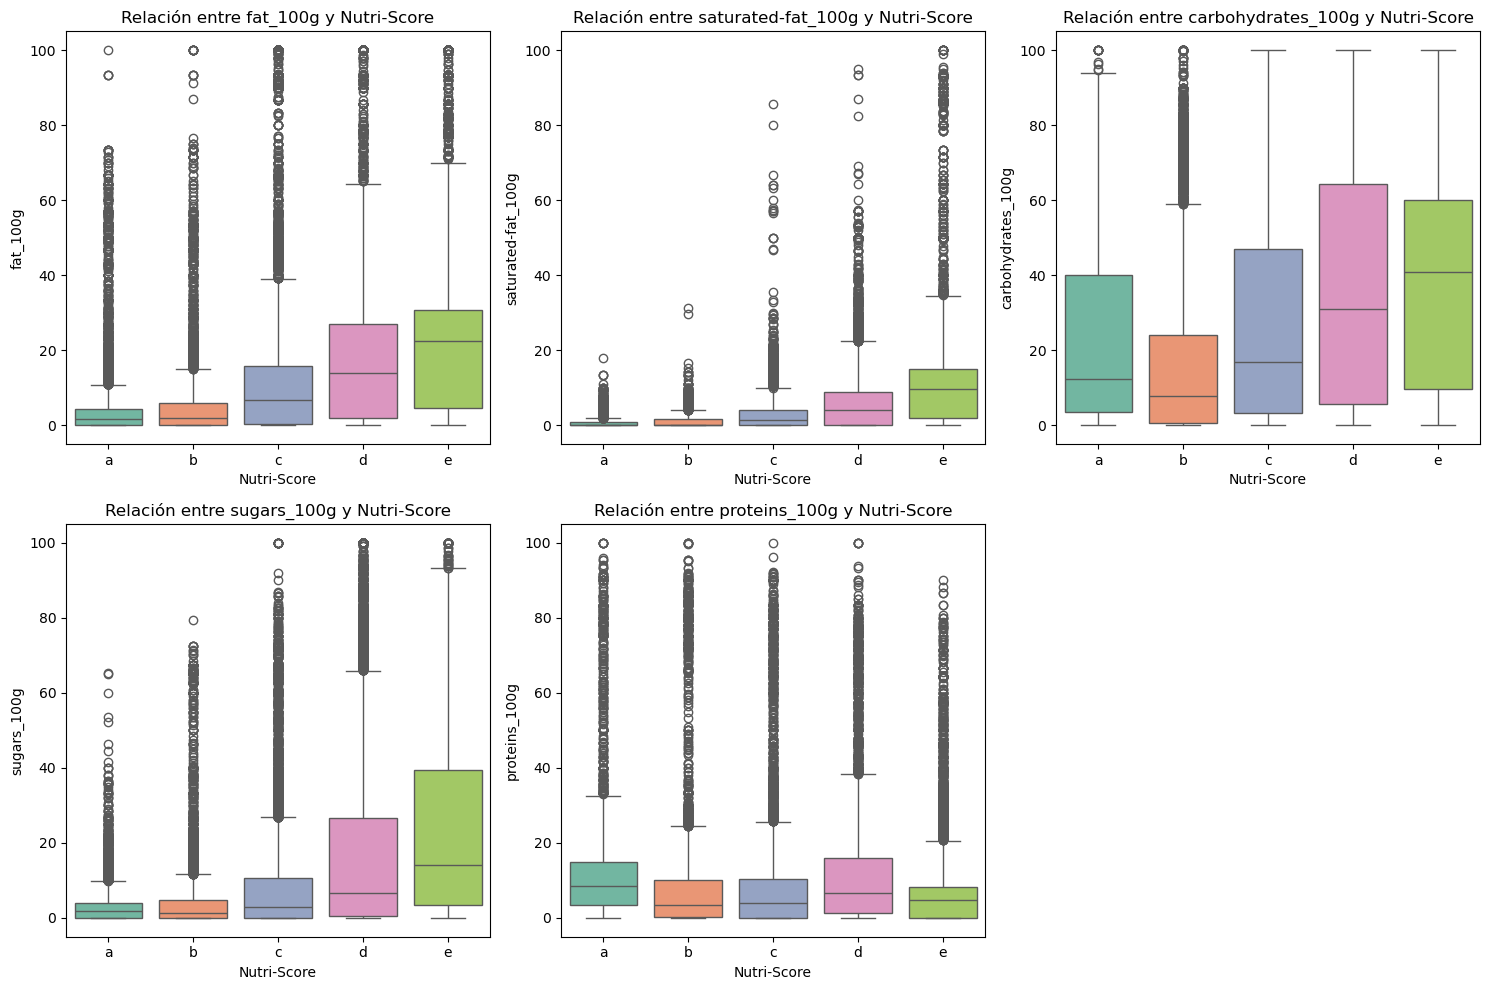

In [58]:
macronutrient_columns = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']
nutriscore_column = 'nutriscore_grade'

# Filtramos el DataFrame para mantener solo las filas con Nutri-Score válido
df_filtered = df_data[df_data[nutriscore_column].notna() & (df_data[nutriscore_column] != 'unknown')].copy()

# Nos aseguramos de que el Nutri-Score es una categoría
df_filtered.loc[:, nutriscore_column] = pd.Categorical(df_filtered[nutriscore_column], categories=['a', 'b', 'c', 'd', 'e'], ordered=True)

# Filtramos el DataFrame para mantener solo las columnas de interés
df_filtered = df_filtered[macronutrient_columns + [nutriscore_column]].dropna()

# Visualización de la relación entre macronutrientes y Nutri-Score usando boxplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(macronutrient_columns):
    plt.subplot(2, 3, i + 1)
    
    sns.boxplot(x=nutriscore_column, y=col, data=df_filtered, hue=nutriscore_column, palette='Set2', legend=False)
    
    plt.title(f'Relación entre {col} y Nutri-Score')
    plt.xlabel('Nutri-Score')
    plt.ylabel(col)

plt.tight_layout()
plt.show()



En general, notamos que un aumento en la cantidad de todos los macronutrientes se asocia con un peor Nutri-Score, excepto en el caso de las proteínas, que no siguen esta misma tendencia. En particular, que un alimento contenga niveles de grasas y/o azúcares elevados suele implicar un Nutri-Score malo.

Conviene también tener una idea de la distribución de los nutriscores, ya que no la hemos visualizado anteriormente

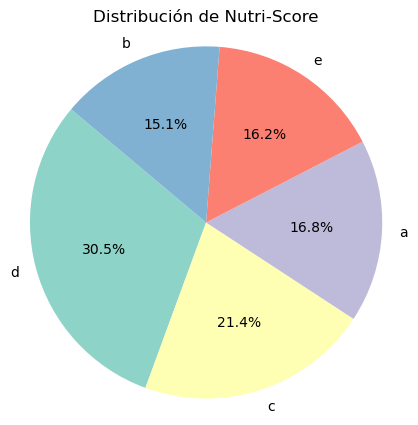

In [59]:
nutriscore_counts = df_filtered[nutriscore_column].value_counts()

# Creamos el pie chart
plt.figure(figsize=(5, 5))
plt.pie(nutriscore_counts, labels=nutriscore_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Distribución de Nutri-Score')
plt.axis('equal')
plt.show()

## 2.4. Análisis de los micronutrientes

Vamos a realizar un breve análisis de los dos micronutrientes que hemos retenido: la sal y el sodio. Si bien hay más micronutrientes en los datos oirginales, recordemos que estos son los mayoritarios. En un primer lugar, vamos a comprobar que efectivamente significan prácticamente lo mismo y por tanto tienen distribuciones similares y una alta correalción:

           salt_100g    sodium_100g
count  293392.000000  293392.000000
mean        1.363125       0.545249
std         3.554128       1.421658
min         0.000000       0.000000
25%         0.130208       0.052083
50%         0.700000       0.280000
75%         1.458333       0.583333
max       100.000000      40.000000


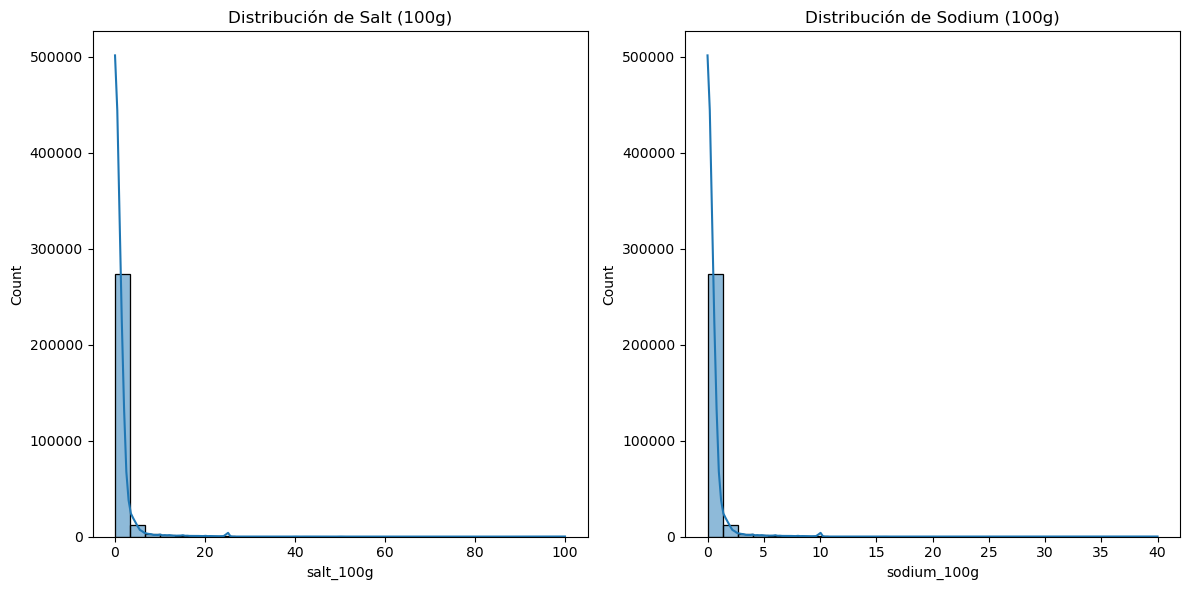

Correlación entre salt_100g y sodium_100g: 0.9999999413412886


In [84]:
# Descripción general de las columnas
print(df_data[['salt_100g', 'sodium_100g', 'nutriscore_grade']].describe())

# Visualizamos la distribución de salt_100g y sodium_100g
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_data['salt_100g'].dropna(), bins=30, kde=True)
plt.title('Distribución de Salt (100g)')

plt.subplot(1, 2, 2)
sns.histplot(df_data['sodium_100g'].dropna(), bins=30, kde=True)
plt.title('Distribución de Sodium (100g)')

plt.tight_layout()
plt.show()

# Correlación entre salt_100g y sodium_100g
correlation = df_data[['salt_100g', 'sodium_100g']].corr().iloc[0, 1]
print(f'Correlación entre salt_100g y sodium_100g: {correlation}')


En este análisis exploratorio de datos, consideraremos únicamente la sal y no el sodio, dado que la correlación entre ambos es muy alta y la sal representa de manera efectiva la variabilidad que deseamos explorar. Veamo salgún gráfico más mostrando información útil:

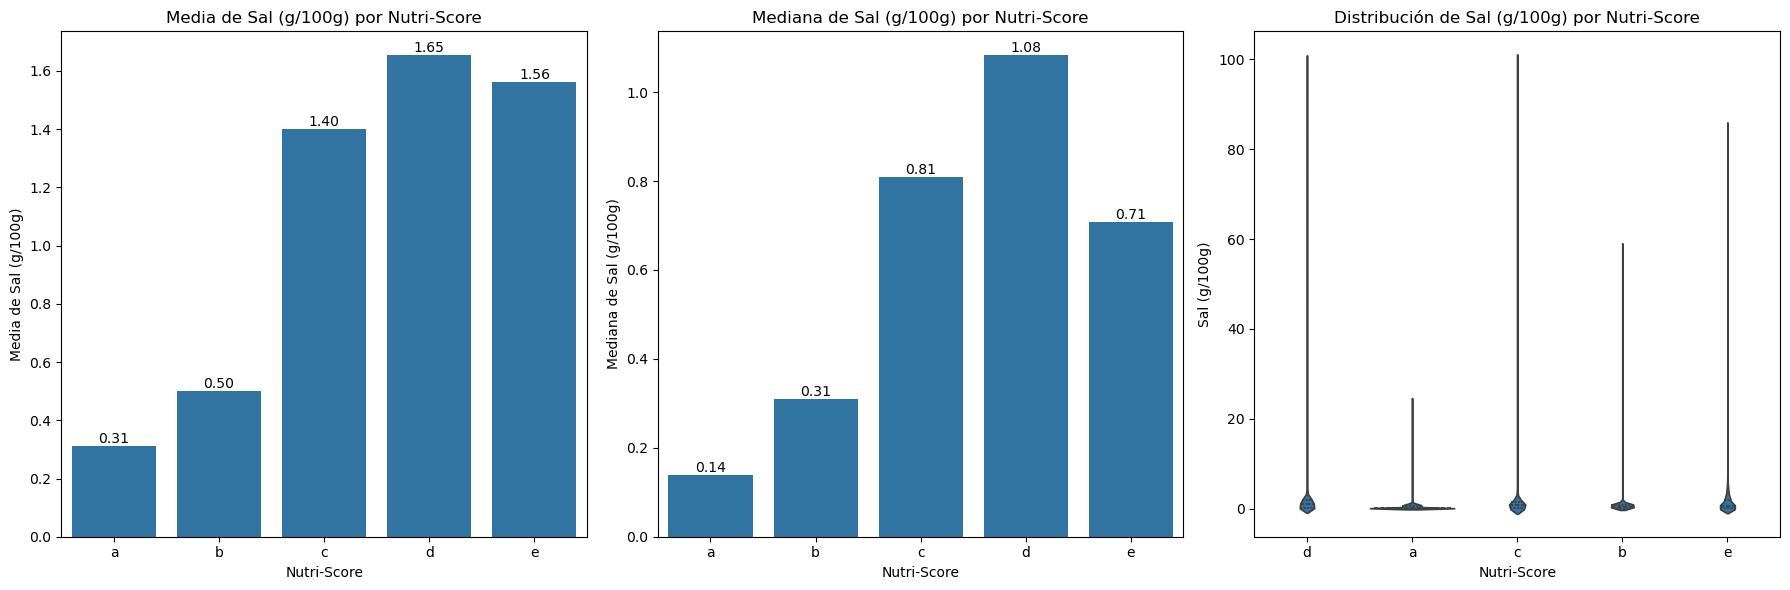

In [85]:
# Filtramos el DataFrame para mantener solo las filas con Nutri-Score válido
df_filtered = df_data[df_data[nutriscore_column].notna() & (df_data[nutriscore_column] != 'unknown')]

# Nos aseguramos de que el Nutri-Score es una categoría
df_filtered.loc[:, nutriscore_column] = pd.Categorical(df_filtered[nutriscore_column], categories=['a', 'b', 'c', 'd', 'e'], ordered=True)

# Calculamos la media y la mediana de sal por Nutri-Score
mean_salt_by_nutriscore = df_filtered.groupby(nutriscore_column, observed=False)['salt_100g'].mean().reset_index()
median_salt_by_nutriscore = df_filtered.groupby(nutriscore_column, observed=False)['salt_100g'].median().reset_index()

# Configuración de la figura para tres subgráficos
plt.figure(figsize=(18, 6))

# Gráfico de barras para la media
plt.subplot(1, 3, 1)
sns.barplot(x=nutriscore_column, y='salt_100g', data=mean_salt_by_nutriscore)
plt.title('Media de Sal (g/100g) por Nutri-Score')
plt.xlabel('Nutri-Score')
plt.ylabel('Media de Sal (g/100g)')

# Agregamos los valores de la media en las barras
for index, row in mean_salt_by_nutriscore.iterrows():
    plt.text(index, row['salt_100g'], f'{row["salt_100g"]:.2f}', ha='center', va='bottom', color='black')

# Gráfico de barras para la mediana
plt.subplot(1, 3, 2)
sns.barplot(x=nutriscore_column, y='salt_100g', data=median_salt_by_nutriscore)
plt.title('Mediana de Sal (g/100g) por Nutri-Score')
plt.xlabel('Nutri-Score')
plt.ylabel('Mediana de Sal (g/100g)')

# Agregamos los valores de la mediana en las barras
for index, row in median_salt_by_nutriscore.iterrows():
    plt.text(index, row['salt_100g'], f'{row["salt_100g"]:.2f}', ha='center', va='bottom', color='black')

# Gráfico de violín
plt.subplot(1, 3, 3)
sns.violinplot(x=nutriscore_column, y='salt_100g', data=df_filtered, inner='quartile')
plt.title('Distribución de Sal (g/100g) por Nutri-Score')
plt.xlabel('Nutri-Score')
plt.ylabel('Sal (g/100g)')

plt.tight_layout()
plt.show()



Vemos que la mayor media de sal está asociada con un Nutri-Score de c. Podemos suponer que las sales puras tienen este Nutri-Score, y que por eso sube la media para ese índice. Vamos a comprobar esto mediante un análisis de los outliers con mayor contenido en sal:

In [90]:
# Filtramos el DataFrame para mantener solo las filas con Nutri-Score válido
df_filtered = df_data[df_data[nutriscore_column].notna() & (df_data[nutriscore_column] != 'unknown')]

# Calculamos los cuartiles
Q1 = df_filtered['salt_100g'].quantile(0.25)
Q3 = df_filtered['salt_100g'].quantile(0.75)
IQR = Q3 - Q1

# Definimos límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificamos outliers
outliers = df_filtered[(df_filtered['salt_100g'] < lower_bound) | (df_filtered['salt_100g'] > upper_bound)]

# Obtenemos el top 10 outliers
top_10_outliers = outliers.nlargest(10, 'salt_100g')[['product_name','salt_100g', nutriscore_column]]

# Mostramos el top 10 outliers
print("Top 10 outliers en contenido de sal:")
print(top_10_outliers)

Top 10 outliers en contenido de sal:
                                product_name  salt_100g nutriscore_grade
72550                                   OREO      100.0                d
84879                       Sea salt grinder      100.0                c
84898          Mediterranean sea salt refill      100.0                c
84934                 Mediterranean sea salt      100.0                c
115084                         Fine Sea Salt      100.0                c
153330                         Fine Sea Salt      100.0                c
176515              Coarse Crystals Sea Salt      100.0                c
329766                       Kosher Sea Salt      100.0                c
329886  All Natural Himalayan Fine Pink Salt      100.0                c
333312                     RAWFISH CRAB BOIL      100.0                c


Vemos que salvo algunas filas que son completamente incorrectas (un error al introducir los datos), los demás outliers que son valores de sal prácticamente iguales a 100g por 100g son efectivamente sales puras, que tienen un Nutri-Score de c, y por tanto elevan la media de la cantidad de sal para esa categoría.

## 2.5. Análisis de las imágenes

Finalmente, ya que vamos a trabajar con imágenes de tablas nutricionales, nos interesa saber qué aspecto tienen.

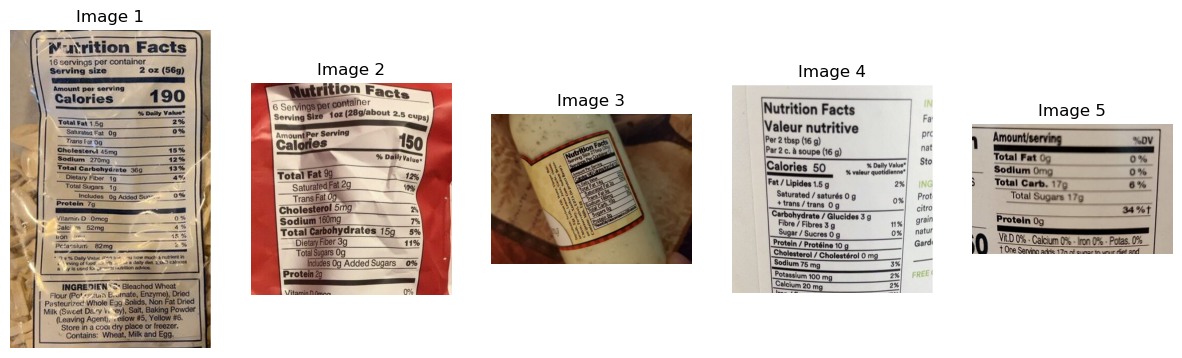

In [77]:
# Mostrar algunas imágenes de las URLs
num_images_to_display = 5
sample_urls = df_data['image_nutrition_url'].dropna().sample(num_images_to_display).tolist()

plt.figure(figsize=(15, 10))
for i, url in enumerate(sample_urls):
    plt.subplot(1, num_images_to_display, i+1)
    
    # Abrir la imagen desde la URL
    with urllib.request.urlopen(url) as response:
        img = Image.open(response)
        plt.imshow(img)
    
    plt.axis('off')  # Ocultar los ejes
    plt.title(f'Image {i+1}')

plt.show()


Podemos hacer una serie de observaciones importantes:

- Las imágenes no tienen la misma dimensión ni orientación, y esto hay que tenerlo en cuenta.

- Hay tablas que se leen de forma muy clara, pero hay otras que son prácticamente ilegibles.

- El contenido de las tablas de información nutricional es variado, tanto en contenido como en idioma.

- Tal y como esperábamos, hay atributos de las tablas de información nutricional que no hemos retenido para hacer este EDA. Sin embargo, es importante tenerlos en cuenta para trabajar con estas tablas.

Vamos a analizar las dimensiones de las imágenes:

            width     height
count  100.000000  100.00000
mean   354.250000  311.78000
std     71.268219   97.93696
min    101.000000   41.00000
25%    300.000000  240.75000
50%    400.000000  336.50000
75%    400.000000  400.00000
max    400.000000  400.00000


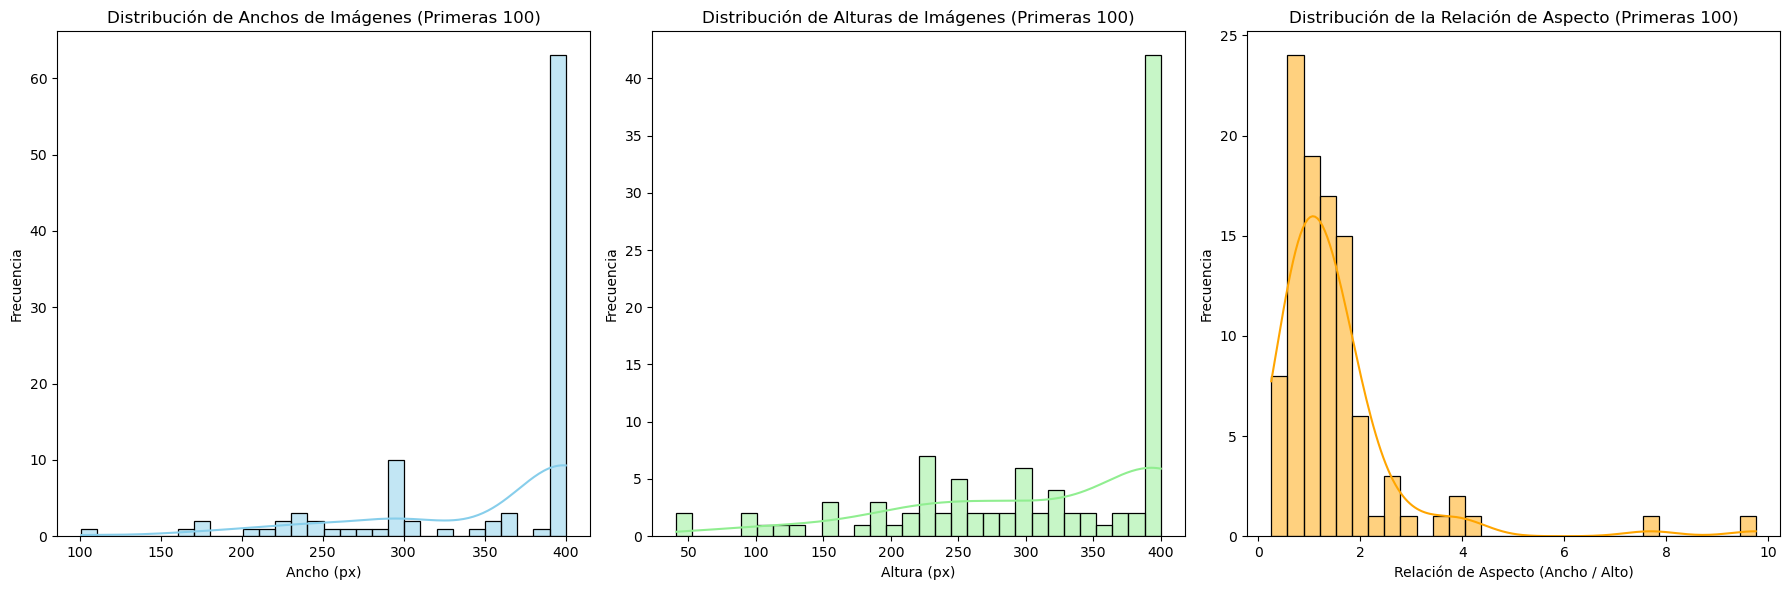

In [91]:
# Función para obtener las dimensiones de las imágenes
def get_image_dimensions(url):
    try:
        with urllib.request.urlopen(url) as response:
            img = Image.open(response)
            return img.size  # Devuelve (ancho, alto)
    except:
        return None  # En caso de error, devuelve None

# Tomamos solo las primeras 100 URLs de imágenes
first_100_urls = df_data['image_nutrition_url'].dropna().head(100)

# Aplicamos la función a las primeras 100 URLs y almacenamos las dimensiones
dimensions = first_100_urls.apply(get_image_dimensions)

# Filtramos las dimensiones válidas
valid_dimensions = dimensions.dropna()

# Creamos un DataFrame con las dimensiones válidas
dimensions_df = pd.DataFrame(valid_dimensions.tolist(), columns=['width', 'height'])

# Análisis estadístico
print(dimensions_df.describe())

# Calculamos la relación de aspecto
dimensions_df['aspect_ratio'] = dimensions_df['width'] / dimensions_df['height']

# Visualización de las dimensiones
plt.figure(figsize=(18, 6))

# Histograma de anchuras
plt.subplot(1, 3, 1)
sns.histplot(dimensions_df['width'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Anchos de Imágenes (Primeras 100)')
plt.xlabel('Ancho (px)')
plt.ylabel('Frecuencia')

# Histograma de alturas
plt.subplot(1, 3, 2)
sns.histplot(dimensions_df['height'], bins=30, kde=True, color='lightgreen')
plt.title('Distribución de Alturas de Imágenes (Primeras 100)')
plt.xlabel('Altura (px)')
plt.ylabel('Frecuencia')

# Histograma de relación de aspecto
plt.subplot(1, 3, 3)
sns.histplot(dimensions_df['aspect_ratio'], bins=30, kde=True, color='orange')
plt.title('Distribución de la Relación de Aspecto (Primeras 100)')
plt.xlabel('Relación de Aspecto (Ancho / Alto)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Observamos que las dimensiones de las imágenes son muy variables. Esta observación es importante para poder trabajar con este tipo de datos. Realicemos ahora un análisis para ver los colores predominantes de las imágenes:

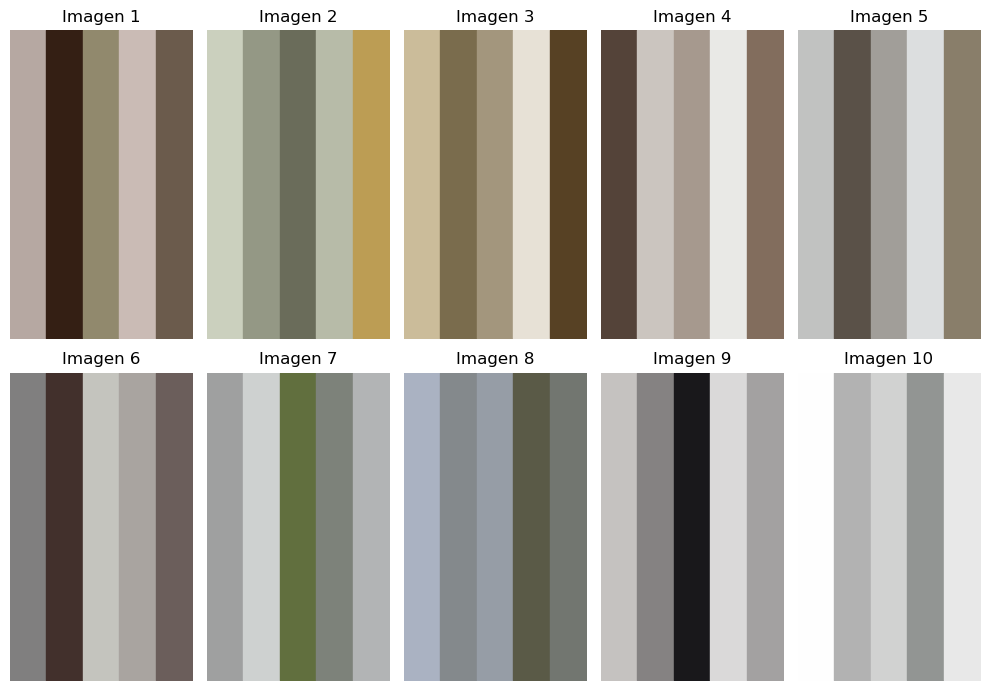

In [93]:
# Función para obtener los colores dominantes de una imagen
def get_dominant_colors(url, num_colors=5):
    try:
        with urllib.request.urlopen(url) as response:
            img = Image.open(response).resize((100, 100))  
            img_array = np.array(img) 
            img_array = img_array.reshape(-1, 3) 

            # Usamos KMeans para encontrar colores dominantes
            kmeans = KMeans(n_clusters=num_colors)
            kmeans.fit(img_array)
            colors = kmeans.cluster_centers_ 
            return colors.astype(int) 
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Definimos el número de colores a extraer
num_colors = 5

# Tomamos solo las primeras 10 URLs de imágenes para el análisis de colores
first_10_urls = df_data['image_nutrition_url'].dropna().head(10)

# Obtenemos los colores dominantes para cada imagen
dominant_colors = first_10_urls.apply(lambda url: get_dominant_colors(url, num_colors))

# Filtramos los colores válidos
valid_colors = dominant_colors.dropna()

# Visualizamos los colores dominantes
plt.figure(figsize=(10, 7))
for i, colors in enumerate(valid_colors):
    plt.subplot(2, 5, i + 1)
    plt.title(f'Imagen {i + 1}')
    
    for j, color in enumerate(colors):
        plt.fill_between([j, j + 1], 0, 1, color=np.array(color) / 255)
    
    plt.xlim(0, num_colors)
    plt.ylim(0, 1)
    plt.axis('off') 

plt.tight_layout()
plt.show()


Observamos que los colores predominantes de las imágenes también son ligeramente variables, como es lógico. Esto será importante a la hora de procesar las imágenes. Una alternativa sencilla para resolver esta variabilidad podría ser binarizar la imagen, aunque hay que tener cuidado con el umbral que fijemos, ya que va a depender de la imagen que estemos empleando.

# Identificación de los datos necesarios para extraer las tablas de las imágenes

La tarea que abordamos es una tarea de OCR (Reconocimiento Óptico de Caracteres), donde queremos extraer texto de imágenes, en este caso, de tablas nutricionales en productos. El proceso de OCR normalmente se descompone en varias etapas distintas, que incluyen la detección y transcripción de texto, aunque también existen enfoques end-to-end que combinan estos pasos.

En general, las etapas de un modelo OCR incluyen:

- Preprocesamiento de la imagen para mejorar su calidad (binarización, aumento de contraste, eliminación de ruido,...)

- Segmentación básica para aislar áreas con texto, y la detección de texto mediante modelos como EAST (Efficient and Accurate Scene Text Detector) o CRAFT (Character Region Awareness for Text Detection). Nótese que para esta etapa también se podrían usar modelos más generales como R-CNN o YOLO, aunque no son modelos específicos para la detección de texto.

- Si es necesario, se segmenta la tabla para organizar los datos (para extraer los datos de manera estructurada). 

- Transcripción del texto, reconociendo nombres de nutrientes y valores (con modelos como Tesseract o CRNN). 

- En el postprocesamiento, se corrigen errores y se normalizan las unidades. 

- Finalmente, se valida el modelo comparando sus predicciones con datos reales para medir su precisión (métricas comunes: accuracy, character error rate, word error rate,...).

Ahora que ya hemos visto el funcionamiento de un modelo de OCR, podemos especificar los datos necesarios. Primero, se necesitan imágenes de productos que incluyan tablas nutricionales visibles en diversas condiciones (diferentes ángulos, iluminación, resoluciones, etiquetas dañadas o con reflejos, ruido visual, texto distorsionado,...). Por lo visto en el EDA que hemos realizado, esto se cumple en la base de datos de OpenFoodFacts. 

Además, si no queremos usar un modelo pre-entrenado, necesitamos tener anotaciones que marquen las áreas de texto en las imágenes, así como definir la estructura completa de las tablas nutricionales, especificando cómo están organizadas en filas y columnas. También se requieren en este caso textos de referencia (ground truth) que contengan la información de las tablas, lo que permitirá entrenar, validar y probar el modelo. En este punto es importante incluir ejemplos en diversos idiomas y formatos de tablas nutricionales, ya que según lo que hemos visto anteriormente las etiquetas de productos pueden variar según el país o la región. Esto puede incluir diferencias en el uso de unidades de medida, abreviaciones, terminología y hasta el diseño de las tablas.

Conviene también tener datos para mejorar el postprocesamiento, creando un conjunto de datos de corrección de errores, que incluya ejemplos de errores comunes de OCR (como confusiones de caracteres) y patrones o diccionarios para la normalización de nombres de nutrientes, valores y unidades.

Por último, se necesitan un conjunto de datos de validación y otro de prueba separados para evaluar el rendimiento final del modelo y verificar su capacidad de generalización a nuevos datos no vistos.